In [32]:
from my_functions import*

In [33]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [34]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

nmin=0
nmax=11575
#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]
ZeroBias_e=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_e"].array())[nmin:nmax]

energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


In [36]:
#Set dr
dr_min=0.05
dr_max=0.32
#Compute isolation
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin, nmax], batch_size=4000)
#Compute ratio
data1=ak.flatten(res1)
ratio1=ak.flatten(res1)/ak.flatten(ZeroBias_pt)

In [52]:
#Select the ZeroBias ratios below a certain number (low ratio)
cut=0.02
mask2=ratio1 <= cut
#Aplly the mask to pt, eta, phi
pt=ak.flatten(ZeroBias_pt)
eta=ak.flatten(ZeroBias_eta)
phi=ak.flatten(ZeroBias_phi)
pt_cut=pt[mask2]
eta_cut=eta[mask2]
phi_cut=phi[mask2]

non_empty_count1= len(pt)
non_empty_count2 = len(pt_cut)

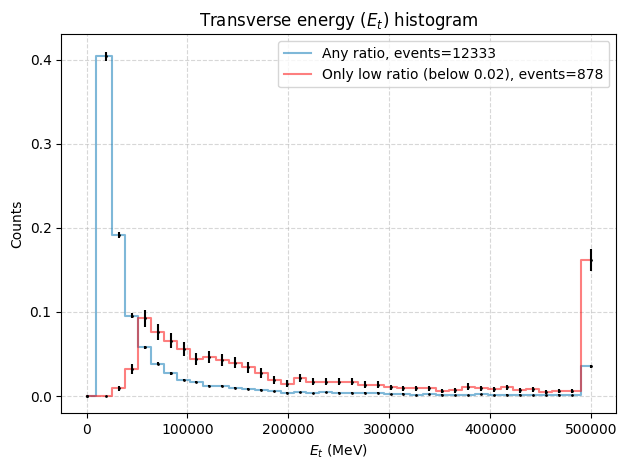

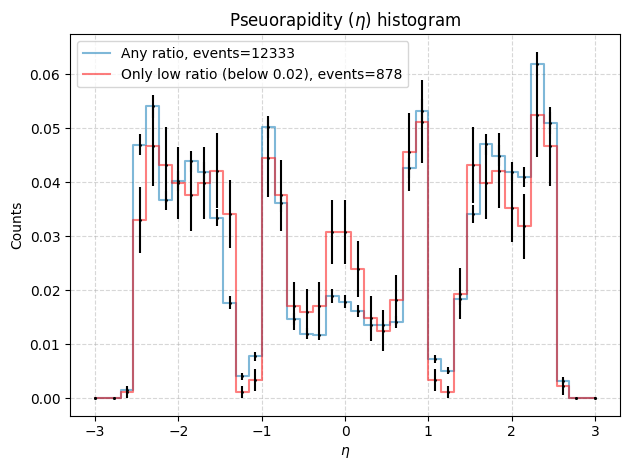

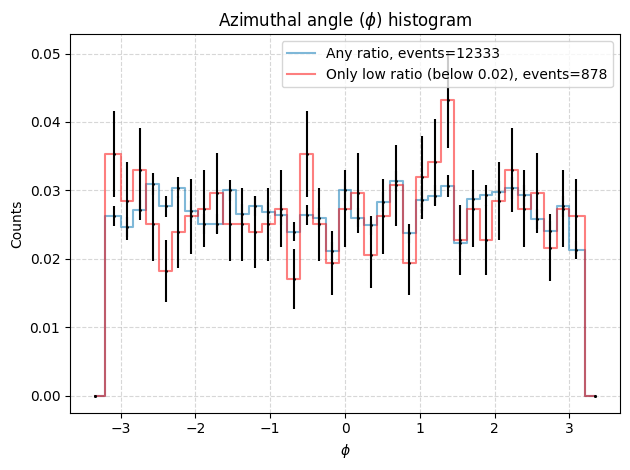

In [57]:
#Plots
coolplot([pt, pt_cut], np.linspace(0,0.5*10**6,40), labels=[f"Any ratio, events={non_empty_count1}", f"Only low ratio (below {cut}), events={non_empty_count2}"],
          title=r"Transverse energy ($E_{t}$) histogram", x_label=r"$E_{t}$ (MeV)", y_label="Counts")
coolplot([eta, eta_cut], np.linspace(-3,3,40),x_label=r"$\eta$", y_label="Counts",labels=[f"Any ratio, events={non_empty_count1}", f"Only low ratio (below {cut}), events={non_empty_count2}"], title=r"Pseuorapidity ($\eta$) histogram")
coolplot([phi, phi_cut], np.linspace(-np.pi-0.2,np.pi+0.2,40),x_label=r"$\phi$", y_label="Counts",labels=[f"Any ratio, events={non_empty_count1}", f"Only low ratio (below {cut}), events={non_empty_count2}"], title=r"Azimuthal angle ($\phi$) histogram")